## ATTEMPT TO USE STATISTICAL PREPROCESSING WTIH GRU MODEL

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import sys
import copy
import optuna
from torch.nn import Dropout
import statsmodels.api as sm

In [2]:
#Reshape the data to create two features 
def get_unrate_ts():
    gru_df = pd.read_csv('UR_data.csv')
    #transform the dataset to work with scaler
    ts = gru_df['UNRATE'].astype(int).values.reshape(-1,1)
    return ts

#print the shape of the dataset
ts = get_unrate_ts()
print(f"Shape of ts: {ts.shape}")

Shape of ts: (914, 1)


In [3]:
#Set best dropout rate for GRU model
class GRU(nn.Module):

    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 out_size = 1,
                 dropout_p=0.24): #set in Optuna trial
        
        super(GRU, self).__init__()
        self.gru = nn.GRU(
            input_size = in_size,
            hidden_size = hidden_size,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)

        # Add dropout layer (optional)
        if dropout_p > 0:
            self.dropout = nn.Dropout(p=dropout_p)
        else:
            self.dropout = None  # No dropout if p is not set
        
    def forward(self, x, h = None):
        out, _ = self.gru(x, h)
        last_hidden_states = out[:, -1]
        
        # Apply dropout if it exists
        if self.dropout is not None:
            last_hidden_states = self.dropout(last_hidden_states)  # Apply dropout
        
        out = self.fc(last_hidden_states)
        
        return out, last_hidden_states

In [4]:
#Training datasets def
def get_training_datasets(ts, features, test_len):
    X, Y = sliding_window(ts, features)

    X_train, Y_train, X_test, Y_test = X[0:-test_len],\
                                       Y[0:-test_len],\
                                       X[-test_len:],\
                                       Y[-test_len:]

    train_len = round(len(ts) * 0.7)

    X_train, X_val, Y_train, Y_val = X_train[0:train_len],\
                                     X_train[train_len:],\
                                     Y_train[0:train_len],\
                                     Y_train[train_len:]

    x_train = torch.tensor(data = X_train).float()
    y_train = torch.tensor(data = Y_train).float()

    x_val = torch.tensor(data = X_val).float()
    y_val = torch.tensor(data = Y_val).float()

    x_test = torch.tensor(data = X_test).float()
    y_test = torch.tensor(data = Y_test).float()

    return x_train, x_val, x_test,\
           y_train.squeeze(1), y_val.squeeze(1), y_test.squeeze(1)

In [5]:
#Sliding window df: Add the CP and HP statistical filters
def sliding_window(ts, features):
    X = []
    Y = []

# 'Unemployment Rate' is at index 1 (check your data)
    train_data = ts  # Extract the unemployment rate

  # Apply HP and CF filters to training data
    train_hp_trend = sm.tsa.filters.hpfilter(train_data)[0]
    train_cf_cycle = sm.tsa.filters.cffilter(train_data)[0]

    for i in range(features, len(train_data)):
    # Create the sliding window for features (unemployment rate)
        window = train_data[i-features:i]

    # Append features and target value
        X.append(window)
        Y.append(train_data[i]) #Reshape target y to 1, 1
    return X, Y

In [6]:
#Added the statisical HP and CP filters to the GRU training

#Best Parameters
training_epochs = 300
gru_hidden_size = 62
learning_rate = 0.05
test_ts_len = 195
dropout_p = 0.24
features = 3
    
#Prepare datasets for training
ts = get_unrate_ts()
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts)
x_train, x_val, x_test, y_train, y_val, y_test = get_training_datasets(scaled_ts, features, test_ts_len)

#Initializing the model
model = GRU(hidden_size = gru_hidden_size)
model.train()
    
#Train LSTM model
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
mse_loss = torch.nn.MSELoss()
best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(training_epochs):
    
    prediction, _ = model(x_train)
    loss = mse_loss(prediction.squeeze(1), y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    val_prediction, _ = model(x_val)
    val_loss = mse_loss(val_prediction.squeeze(1), y_val)
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()

    if t % 10 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}', f'val: - {round(val_loss.item(), 4)}')    

epoch 0: train - 0.1519 val: - 0.1143
epoch 10: train - 0.0214 val: - 0.0041
epoch 20: train - 0.0091 val: - 0.0052
epoch 30: train - 0.0042 val: - 0.0031


/var/folders/pr/r9s7fv8d3hl7zl078q3rzs_00000gn/T/ipykernel_26123/567976264.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  x_train = torch.tensor(data = X_train).float()


epoch 40: train - 0.0023 val: - 0.0016
epoch 50: train - 0.0016 val: - 0.0011
epoch 60: train - 0.0018 val: - 0.0011
epoch 70: train - 0.0016 val: - 0.0008
epoch 80: train - 0.0014 val: - 0.0009
epoch 90: train - 0.0014 val: - 0.0009
epoch 100: train - 0.0014 val: - 0.0008
epoch 110: train - 0.0013 val: - 0.0008
epoch 120: train - 0.0013 val: - 0.0008
epoch 130: train - 0.0013 val: - 0.0008
epoch 140: train - 0.0013 val: - 0.0007
epoch 150: train - 0.0012 val: - 0.0007
epoch 160: train - 0.0013 val: - 0.0008
epoch 170: train - 0.0013 val: - 0.0008
epoch 180: train - 0.0013 val: - 0.0007
epoch 190: train - 0.0012 val: - 0.0007
epoch 200: train - 0.0013 val: - 0.0007
epoch 210: train - 0.0014 val: - 0.0007
epoch 220: train - 0.0013 val: - 0.0008
epoch 230: train - 0.0012 val: - 0.0007
epoch 240: train - 0.0012 val: - 0.0007
epoch 250: train - 0.0012 val: - 0.0007
epoch 260: train - 0.0012 val: - 0.0007
epoch 270: train - 0.0013 val: - 0.0007
epoch 280: train - 0.0013 val: - 0.0007
epoch 

In [7]:
#Evaluate the GRU model

best_model.eval()
_, h_list = best_model(x_val) # -, is used to disgard the output predictions because they aren't needed here.

#Warm hidden state
h = (h_list[-1, :]).unsqueeze(-2) # [-1,:] takes the last hidden state. Unsqueeze(-2) adds 2d diminsion to match output.

gru_predicted = []

for test_seq in x_test.tolist():
    x = torch.Tensor(data =[test_seq]) #Converst the test_seq to a PyTorch tensor
    
    #Passing the hidden state through each iteration
    y, h = best_model(x, h.unsqueeze(-2)) #Passes x and h (warm hidden state) through the model.
    
    #returns the predicted y back to its original scale and reshapes output data to 2D array extracted as a single value
    unscaled = scaler.inverse_transform(np.array(y.item()).reshape(-1, 1))[0][0]
    
    gru_predicted.append(unscaled)

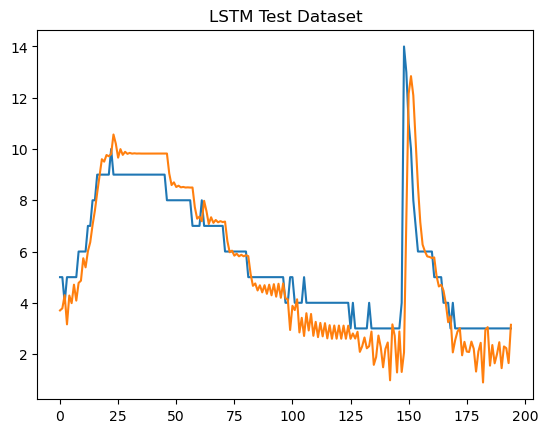

In [8]:
#Performance on the GRU test dataset
real = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.title("GRU Test Dataset with CF & HP Filters")
plt.plot(real, label = 'real')
plt.plot(gru_predicted, label = 'GRU_predicted')
plt.legend
plt.show()

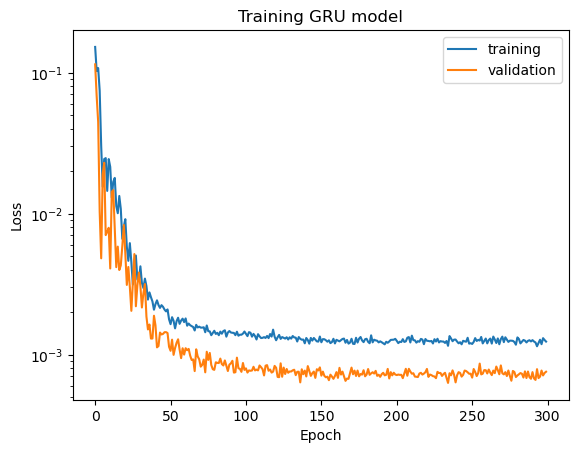

In [9]:
#Training progress with GRU Model
plt.title('Training GRU model')
plt.yscale('log')
plt.plot(training_loss, label = 'training')
plt.plot(validation_loss, label = 'validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [10]:
# Attempt at calculating the best model MSE
from sklearn.metrics import mean_squared_error

best_model.eval()
test_prediction, _ = best_model(x_test)

#Convert tensors to numpy arrays
y_test_np = y_test.detach().numpy()
test_prediction_np = test_prediction.detach().numpy()

# Calculating the accuracy score
#threshold = 0.1
mse = mean_squared_error(y_test_np, test_prediction_np)

print(f"GRU MSE: {mse}")

GRU MSE: 0.005502148065716028


In [11]:
#Attempt at calculating the best model R-squared score
from sklearn.metrics import r2_score

r2 = r2_score(y_test_np, test_prediction_np)

print(f"GRU R-Squared: {r2}")

GRU R-Squared: 0.853647373559561


## 2ND ATTEMPT: OPTUNA TRIAL WITH THE CP AND HP FILTERS ENACTED

In [12]:
#Optuna trial for GRU model with HP & CP filters
def objective(trial, GRU, get_unrate_ts, get_training_datasets, sliding_window):
    
    #Fixed Parameters in GRU model
    training_epochs = 300
    
    # Suggest lstm_hidden size, learning rate, test_ts_len, eatures
    gru_hidden_size = trial.suggest_int("lstm_hidden_size", 24, 68)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.05)
    test_ts_len = trial.suggest_int("test_ts_len", 100, 200)
    dropout_p = trial.suggest_float("dropout_p", 0.10, 0.50)
    features = trial.suggest_int("features", 2, 24)
    
    #Prepare datasets for training
    ts = get_unrate_ts()
    scaler = MinMaxScaler()
    scaled_ts = scaler.fit_transform(ts)
    x_train, x_val, x_test, y_train, y_val, y_test = get_training_datasets(scaled_ts, features, test_ts_len)

    #Initializing the model
    model = GRU(hidden_size = gru_hidden_size)
    model.train()
    
    #Train LSTM model
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    mse_loss = torch.nn.MSELoss()
    best_model = None
    min_val_loss = sys.maxsize

    training_loss = []
    validation_loss = []

    for t in range(training_epochs):
    
        prediction, _ = model(x_train)
        loss = mse_loss(prediction.squeeze(1), y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        val_prediction, _ = model(x_val)
        val_loss = mse_loss(val_prediction.squeeze(1), y_val)
        training_loss.append(loss.item())
        validation_loss.append(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()
    
    return min_val_loss #Return min validation loss for comparison

# Optuna study
study = optuna.create_study(
    storage ="sqlite:///GRU.sqlite3",
    study_name = "GRU+_02")

# Optimize Study
study.optimize(lambda trial: objective(trial, GRU, get_unrate_ts, get_training_datasets, sliding_window), n_trials=100)

#Access best params and best trial
best_params = study.best_params
best_trial = study.best_trial

[I 2024-04-14 08:55:38,847] A new study created in RDB with name: GRU+_02
[I 2024-04-14 08:55:42,704] Trial 0 finished with value: 0.0015854252269491553 and parameters: {'lstm_hidden_size': 63, 'learning_rate': 0.004454261010578071, 'test_ts_len': 101, 'dropout_p': 0.4891279257000466, 'features': 9}. Best is trial 0 with value: 0.0015854252269491553.
[I 2024-04-14 08:55:43,713] Trial 1 finished with value: 0.0015258488710969687 and parameters: {'lstm_hidden_size': 25, 'learning_rate': 0.016927609417790576, 'test_ts_len': 122, 'dropout_p': 0.47368164638995575, 'features': 5}. Best is trial 1 with value: 0.0015258488710969687.
[I 2024-04-14 08:55:47,167] Trial 2 finished with value: 0.0009111549588851631 and parameters: {'lstm_hidden_size': 48, 'learning_rate': 0.009477764731988114, 'test_ts_len': 200, 'dropout_p': 0.12039389712393245, 'features': 13}. Best is trial 2 with value: 0.0009111549588851631.
[I 2024-04-14 08:55:57,204] Trial 3 finished with value: 0.0016858408926054835 and par

In [13]:
print(best_params)

{'lstm_hidden_size': 30, 'learning_rate': 0.013153383530403684, 'test_ts_len': 198, 'dropout_p': 0.17746967336863795, 'features': 24}


In [ ]:
#Reconfigure the GRU model for best Dropout Rate
class GRU(nn.Module):

    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 out_size = 1,
                 dropout_p=0.18): #set in Optuna trial
        
        super(GRU, self).__init__()
        self.gru = nn.GRU(
            input_size = in_size,
            hidden_size = hidden_size,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)

        # Add dropout layer (optional)
        if dropout_p > 0:
            self.dropout = nn.Dropout(p=dropout_p)
        else:
            self.dropout = None  # No dropout if p is not set
        
    def forward(self, x, h = None):
        out, _ = self.gru(x, h)
        last_hidden_states = out[:, -1]
        
        # Apply dropout if it exists
        if self.dropout is not None:
            last_hidden_states = self.dropout(last_hidden_states)  # Apply dropout
        
        out = self.fc(last_hidden_states)
        
        return out, last_hidden_states

In [14]:
#Use Best params with the HP & CP filters for GRU model
training_epochs = 300
gru_hidden_size = 30
learning_rate = 0.013
test_ts_len = 198
dropout_p = 0.18
features = 24
    
#Prepare datasets for training
ts = get_unrate_ts()
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts)
x_train, x_val, x_test, y_train, y_val, y_test = get_training_datasets(scaled_ts, features, test_ts_len)

#Initializing the model
model = GRU(hidden_size = gru_hidden_size)
model.train()
    
#Train LSTM model
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
mse_loss = torch.nn.MSELoss()
best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(training_epochs):
    
    prediction, _ = model(x_train)
    loss = mse_loss(prediction.squeeze(1), y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    val_prediction, _ = model(x_val)
    val_loss = mse_loss(val_prediction.squeeze(1), y_val)
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()

    if t % 10 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}', f'val: - {round(val_loss.item(), 4)}')    

epoch 0: train - 0.1895 val: - 0.0421
epoch 10: train - 0.0227 val: - 0.0084
epoch 20: train - 0.0106 val: - 0.0061
epoch 30: train - 0.0073 val: - 0.0051
epoch 40: train - 0.0047 val: - 0.0034
epoch 50: train - 0.0037 val: - 0.0022
epoch 60: train - 0.0033 val: - 0.0016
epoch 70: train - 0.003 val: - 0.0016
epoch 80: train - 0.0028 val: - 0.0016
epoch 90: train - 0.0026 val: - 0.0016
epoch 100: train - 0.0026 val: - 0.0014
epoch 110: train - 0.0023 val: - 0.0012
epoch 120: train - 0.0021 val: - 0.0013
epoch 130: train - 0.0025 val: - 0.0013
epoch 140: train - 0.0024 val: - 0.0015
epoch 150: train - 0.0023 val: - 0.0012
epoch 160: train - 0.0022 val: - 0.0014
epoch 170: train - 0.0019 val: - 0.0011
epoch 180: train - 0.002 val: - 0.0017
epoch 190: train - 0.0018 val: - 0.0012
epoch 200: train - 0.0022 val: - 0.0007
epoch 210: train - 0.0019 val: - 0.0009
epoch 220: train - 0.0018 val: - 0.0011
epoch 230: train - 0.0016 val: - 0.001
epoch 240: train - 0.0017 val: - 0.0007
epoch 250: tra

In [15]:
#Evaluate the GRU model

best_model.eval()
_, h_list = best_model(x_val) # -, is used to disgard the output predictions because they aren't needed here.

#Warm hidden state
h = (h_list[-1, :]).unsqueeze(-2) # [-1,:] takes the last hidden state. Unsqueeze(-2) adds 2d diminsion to match output.

gru_predicted = []

for test_seq in x_test.tolist():
    x = torch.Tensor(data =[test_seq]) #Converst the test_seq to a PyTorch tensor
    
    #Passing the hidden state through each iteration
    y, h = best_model(x, h.unsqueeze(-2)) #Passes x and h (warm hidden state) through the model.
    
    #returns the predicted y back to its original scale and reshapes output data to 2D array extracted as a single value
    unscaled = scaler.inverse_transform(np.array(y.item()).reshape(-1, 1))[0][0]
    
    gru_predicted.append(unscaled)

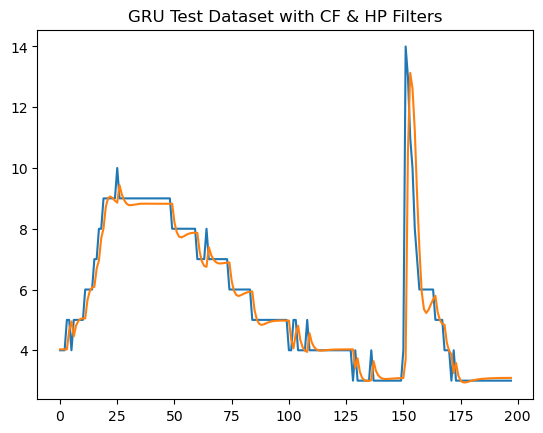

In [16]:
#Performance on the GRU test dataset
real = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.title("GRU Test Dataset with CF & HP Filters - Optimized")
plt.plot(real, label = 'real')
plt.plot(gru_predicted, label = 'GRU_predicted')
plt.legend
plt.show()

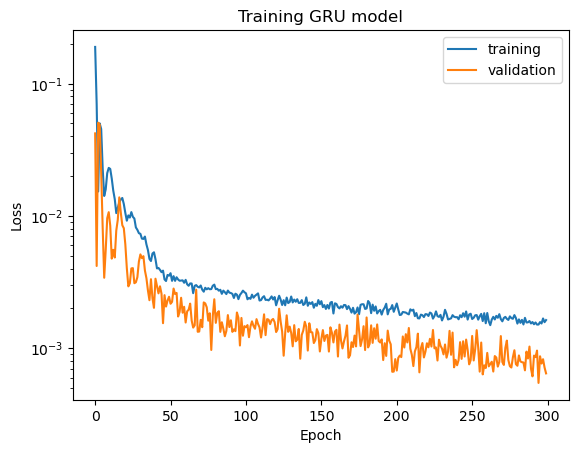

In [17]:
#Training progress with GRU Model
plt.title('Training GRU model')
plt.yscale('log')
plt.plot(training_loss, label = 'training')
plt.plot(validation_loss, label = 'validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [18]:
# Attempt at calculating the best model MSE
from sklearn.metrics import mean_squared_error

best_model.eval()
test_prediction, _ = best_model(x_test)

#Convert tensors to numpy arrays
y_test_np = y_test.detach().numpy()
test_prediction_np = test_prediction.detach().numpy()

# Calculating the accuracy score
#threshold = 0.1
mse = mean_squared_error(y_test_np, test_prediction_np)

print(f"GRU MSE: {mse}")

GRU MSE: 0.005929790437221527


In [19]:
#Attempt at calculating the best model R-squared score
from sklearn.metrics import r2_score

r2 = r2_score(y_test_np, test_prediction_np)

print(f"GRU R-Squared: {r2}")

GRU R-Squared: 0.8410217188891822


In [20]:
print(gru_predicted)

[4.029993414878845, 4.0302687883377075, 4.0304765701293945, 4.030618190765381, 4.650925517082214, 4.951841115951538, 4.45785117149353, 4.808753490447998, 4.965908050537109, 5.0330140590667725, 5.0542696714401245, 5.045525670051575, 5.6535080671310425, 5.946866273880005, 6.066686272621155, 6.085582256317139, 6.682331562042236, 6.957230091094971, 7.688149929046631, 8.006404399871826, 8.720767498016357, 9.007929801940918, 9.06203031539917, 9.006925582885742, 8.923571825027466, 8.85854721069336, 9.43687653541565, 9.13118052482605, 8.946771144866943, 8.830990552902222, 8.779293298721313, 8.774727821350098, 8.787479400634766, 8.80372142791748, 8.816432237625122, 8.823450326919556, 8.82602596282959, 8.826011657714844, 8.824955224990845, 8.823829412460327, 8.823023319244385, 8.822609901428223, 8.822477579116821, 8.82250690460205, 8.822582721710205, 8.822657823562622, 8.822709321975708, 8.822734355926514, 8.82274079322815, 8.8227379322052, 8.210629224777222, 7.887169122695923, 7.742154598236084

## Conclusion: The GRU model with CP & HP statisticala filters worked with a 0.005 MSE rate and 0.84% R-Squared rate. this model holds promise! For next steps to predict unemployment rates for the next 12 months, consider the following: 1) training with a smaller dataset that is more relevant to the more recent changes in the unemployment rate (what happened 30 years ago isn't relevant to the next 12 months) and after that, consider layering in additional data features suchs as Interest Rates and CPI to build in the GRU model. Exciting Stuff! To summate, you tried the SARIMA model which was interesting and yielded good predictive unemployment rate results, the RNN model that yielded a 0.025% MSE but a low r squared value of 0.14, the LSTM model which yielded a 0.14% MSE and a low r squared value of -2.59, and the GRU model with CP & HP filters which yielded the best results of a 0.00% MSE and 0.84 r squared ratio!